# EE4331 Machine Learning Final Project:
## Using EEG Signals to Determine Neurological Disorders with Machine Learning

### David Sharp     eor13
### Fall 2024

## 0. Imports

In [1]:
import mne
from mne.preprocessing import ICA, create_eog_epochs
from mne.io import read_raw_eeglab
from mne import create_info
from mne.io import RawArray
from scipy.signal import resample
from scipy.signal import butter, sosfilt
from scipy.stats import iqr
from scipy.signal import butter, sosfiltfilt
from pathlib import Path
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## 1. Participant Metadata

In [2]:
# Load the TSV file into a DataFrame
file_path = "C:/Users/dshar/OneDrive/Documents/School/EE4331 Machine Learning/Final Project/Dataset/participants.tsv"
patient_df = pd.read_csv(file_path, sep='\t')

patient_df = patient_df.rename(columns={'participant_id': 'SubjectID'})

# View the first few rows to understand the structure
print(patient_df.head())

  SubjectID Gender  Age Group  MMSE
0   sub-001      F   57     A    16
1   sub-002      F   78     A    22
2   sub-003      M   70     A    14
3   sub-004      F   67     A    20
4   sub-005      M   70     A    22


In [3]:
# Group by the 'Category' column and calculate the mean of other columns
group_means = patient_df.groupby('Group').mean(numeric_only=True)

# Display the results
print(group_means)

             Age       MMSE
Group                      
A      66.388889  17.750000
C      67.896552  30.000000
F      63.652174  22.173913


In [4]:
group_counts = patient_df['Group'].value_counts()
print(group_counts)

Group
A    36
C    29
F    23
Name: count, dtype: int64


In [5]:
gender_counts = patient_df.groupby(['Group', 'Gender']).size().reset_index(name='count')

print("Count of each gender per category:")
print(gender_counts)

Count of each gender per category:
  Group Gender  count
0     A      F     24
1     A      M     12
2     C      F     11
3     C      M     18
4     F      F      9
5     F      M     14


## Metadata Discussion

From the cells above, it can be seen that there are 88 total patients that have participated in the EEG exam for this study. There are 44 males and 44 females. There are 36 Alzheimer's patients, 29 control patients, and 23 frontotemporal dementia patients. Each EEG reading has 19 channels (electrodes) with a sampling frequency of 500 Hz.

**Alzheimer's:**
* 24 Female / 12Male
* Average Age: 66.4 Years
* Average MMSE: 17.75

**Frontotemporal Dementia:**
* 9 Female / 14 Male
* Average Age: 63.4 Years
* Average MMSE: 22.17

**Control:**
* 11 Female / 18 Male
* Average Age: 67.9 Years
* Average MMSE: 30


## 2. Load EEG Datasets and Preprocessing

### 2.a Plot Raw EEG File

Using matplotlib as 2D backend.


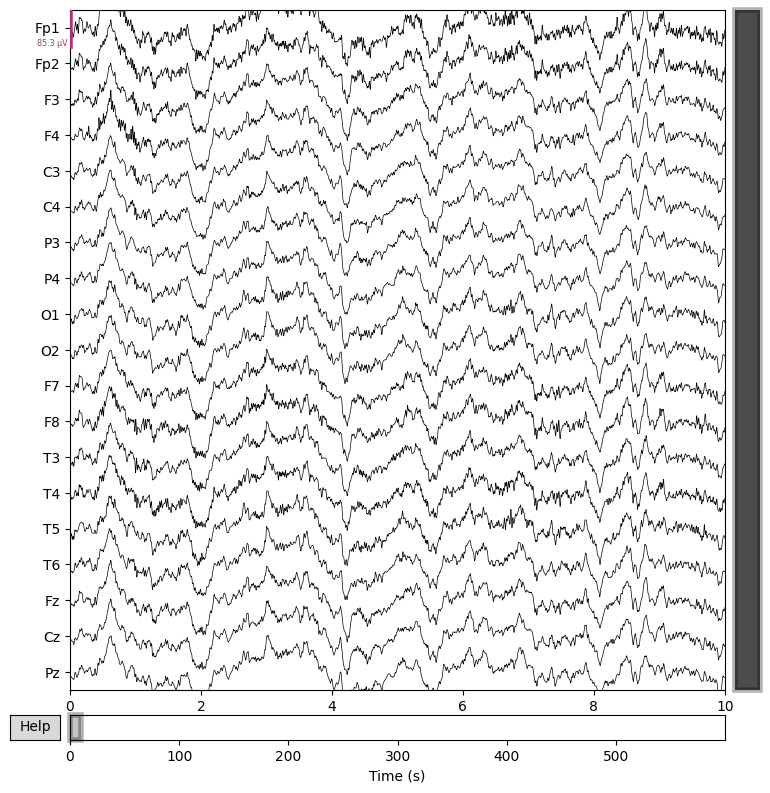

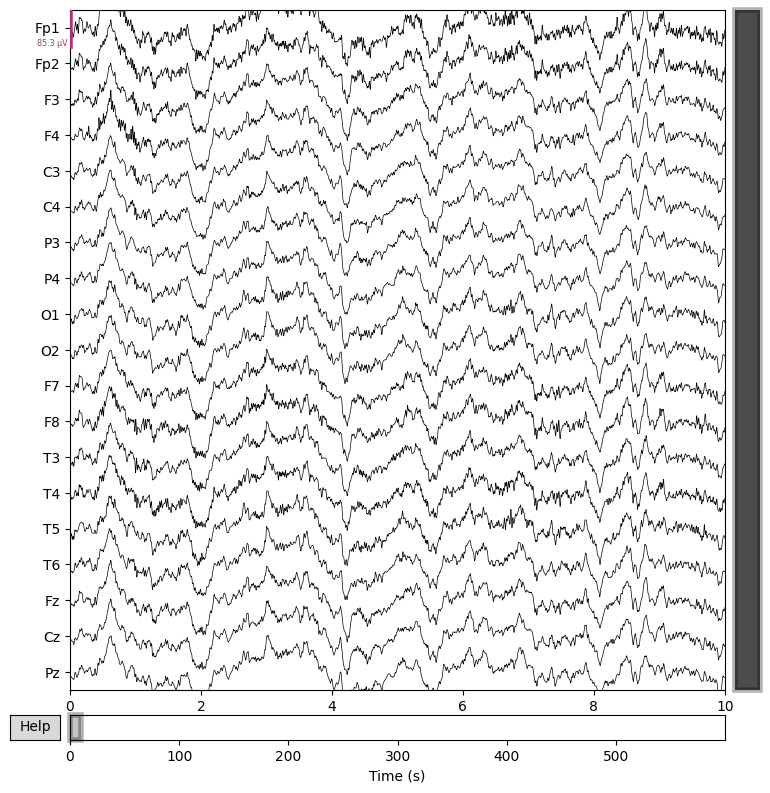

In [6]:
# Path to the patient's .set file
patient_file = 'C:/Users/dshar/OneDrive/Documents/School/EE4331 Machine Learning/Final Project/Dataset/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set'

# Load the EEG data using MNE
raw = read_raw_eeglab(patient_file, preload=True)

# Plot the raw EEG data
raw.plot(n_channels=19, duration=10, scalings='auto', title='Raw EEG Data for Single Patient', show=True)

### 2.b Read all EEGs into dataframe

In [7]:
# Define the path to the directory containing the EEG data
main_dir = Path("C:/Users/dshar/OneDrive/Documents/School/EE4331 Machine Learning/Final Project/Dataset/derivatives/")  

# Initialize an empty list to store each patient's data
data_list = []

# Search through subdirectories to load all .set files
file_paths = glob.glob(str(main_dir / 'sub-**' / 'eeg' / '*.set'), recursive = True)

for file_path in file_paths:
    
    # Load the EEG data file
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    
    # Extract data and channel names
    data, times = raw.get_data(return_times=True)
    channel_names = raw.ch_names
    
    # Create a DataFrame for this patient
    df = pd.DataFrame(data.T, columns=channel_names)
    df['Time'] = times  # Add a time column
    
    # Add patient ID from filename or folder structure
    subject_id = Path(file_path).stem
    df['SubjectID'] = subject_id
    
    # Append to the list
    data_list.append(df)

# Concatenate all dataframes
eeg_df = pd.concat(data_list, ignore_index=True)

# Display dataframe shape
print(f"DataFrame shape: {eeg_df.shape}")

# Display the final DataFrame
print(eeg_df.head())
print(eeg_df.tail())

# Extract just the subject ID (e.g., 'sub-001', 'sub-002')
eeg_df['SubjectID_clean'] = eeg_df['SubjectID'].str.split('_').str[0]

C:\Users\dshar\AppData\Local\Temp\ipykernel_21632\1568875342.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\dshar\AppData\Local\Temp\ipykernel_21632\1568875342.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\dshar\AppData\Local\Temp\ipykernel_21632\1568875342.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\dshar\AppData\Local\Temp\ipykernel_21632\1568875342.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching a

DataFrame shape: (34915560, 21)
        Fp1       Fp2        F3        F4        C3        C4        P3  \
0 -0.000034 -0.000025 -0.000011 -0.000015 -0.000015 -0.000018 -0.000013   
1 -0.000028 -0.000021 -0.000011 -0.000013 -0.000014 -0.000016 -0.000012   
2 -0.000023 -0.000017 -0.000012 -0.000012 -0.000013 -0.000014 -0.000011   
3 -0.000018 -0.000013 -0.000013 -0.000010 -0.000013 -0.000012 -0.000011   
4 -0.000015 -0.000011 -0.000014 -0.000009 -0.000013 -0.000011 -0.000011   

         P4        O1        O2  ...        F8        T3        T4        T5  \
0 -0.000015 -0.000014 -0.000015  ... -0.000017 -0.000016 -0.000016 -0.000012   
1 -0.000014 -0.000015 -0.000013  ... -0.000014 -0.000015 -0.000014 -0.000014   
2 -0.000012 -0.000016 -0.000013  ... -0.000011 -0.000015 -0.000013 -0.000015   
3 -0.000011 -0.000016 -0.000012  ... -0.000009 -0.000015 -0.000013 -0.000017   
4 -0.000011 -0.000017 -0.000012  ... -0.000008 -0.000014 -0.000013 -0.000018   

         T6        Fz        Cz     

### 2.c Select number of participants to use per group

In [9]:
# Choose seed for repeatability
random.seed(42)

# Define the ranges of subjects for each group
group_A_subjects = [f'sub-{i:03}' for i in range(1, 37)]  # Subjects 1-36
group_C_subjects = [f'sub-{i:03}' for i in range(37, 66)]  # Subjects 37-65
group_F_subjects = [f'sub-{i:03}' for i in range(66, 89)]  # Subjects 66-88

# Randomly sample a specific number of subjects from each group (e.g., 10 subjects per group)
num_subjects_per_group = 3
selected_A_subjects = random.sample(group_A_subjects, num_subjects_per_group)
selected_C_subjects = random.sample(group_C_subjects, num_subjects_per_group)
selected_F_subjects = random.sample(group_F_subjects, num_subjects_per_group)

# Combine the selected subjects from all groups
selected_subjects = selected_A_subjects + selected_C_subjects + selected_F_subjects

# Filter the eeg_df_filtered dataframe to only include the selected subjects
balanced_subset = eeg_df[eeg_df['SubjectID_clean'].isin(selected_subjects)]

# Print the subset to confirm
print(balanced_subset.head())
print(balanced_subset.tail())

print("Selected Subjects: ", selected_subjects)

             Fp1       Fp2        F3        F4        C3        C4        P3  \
299900 -0.000014 -0.000013 -0.000013 -0.000015 -0.000014 -0.000014 -0.000013   
299901 -0.000011 -0.000011 -0.000011 -0.000013 -0.000013 -0.000012 -0.000012   
299902 -0.000010 -0.000011 -0.000010 -0.000010 -0.000011 -0.000011 -0.000012   
299903 -0.000009 -0.000011 -0.000010 -0.000008 -0.000011 -0.000011 -0.000013   
299904 -0.000008 -0.000013 -0.000010 -0.000007 -0.000012 -0.000011 -0.000015   

              P4        O1        O2  ...        T3        T4        T5  \
299900 -0.000012 -0.000011 -0.000016  ... -0.000009 -0.000006 -0.000011   
299901 -0.000010 -0.000009 -0.000015  ... -0.000009 -0.000006 -0.000009   
299902 -0.000010 -0.000009 -0.000014  ... -0.000009 -0.000007 -0.000009   
299903 -0.000010 -0.000010 -0.000014  ... -0.000012 -0.000009 -0.000011   
299904 -0.000011 -0.000012 -0.000016  ... -0.000015 -0.000012 -0.000013   

              T6        Fz        Cz        Pz   Time  \
299900 -0.0

### 2.d Resample data at lower freqeuncy

In [10]:
# Define target sampling rate
target_sampling_rate = 125  # Hz

# Extract unique subjects
unique_subjects = balanced_subset['SubjectID'].unique()

# Store resampled data
resampled_data_list = []

# Loop through each subject
for subject in unique_subjects:
    # Subset data for the subject
    subject_data = eeg_df[eeg_df['SubjectID'] == subject].copy()
    
    # Extract channel data and sampling frequency
    data = subject_data.iloc[:, :-2].to_numpy().T  # Exclude 'Time' and 'SubjectID'
    original_sampling_rate = 500  # Replace with your dataset's original rate
    
    # Resample data
    num_samples = int((len(subject_data) / original_sampling_rate) * target_sampling_rate)
    resampled_data = resample(data, num_samples, axis=1)
    
    # Create a new time array for the resampled data
    new_times = np.linspace(0, subject_data['Time'].iloc[-1], num_samples)
    
    # Convert resampled data back to DataFrame
    resampled_df = pd.DataFrame(resampled_data.T, columns=subject_data.columns[:-2])
    resampled_df['Time'] = new_times
    resampled_df['SubjectID'] = subject
    
    # Append to list
    resampled_data_list.append(resampled_df)

# Concatenate all resampled data
eeg_df_resampled = pd.concat(resampled_data_list, ignore_index=True)

# Display results
print(f"Resampled DataFrame shape: {eeg_df_resampled.shape}")
print(eeg_df_resampled.head())
print(eeg_df_resampled.tail())

Resampled DataFrame shape: (887478, 21)
        Fp1       Fp2            F3        F4        C3        C4        P3  \
0 -0.000010 -0.000009 -1.088844e-05 -0.000010 -0.000011 -0.000011 -0.000010   
1 -0.000009 -0.000014 -1.039432e-05 -0.000008 -0.000013 -0.000012 -0.000016   
2 -0.000005 -0.000021 -1.023942e-05 -0.000001 -0.000016 -0.000011 -0.000020   
3  0.000004 -0.000013 -2.292427e-06 -0.000001 -0.000009 -0.000006 -0.000010   
4  0.000002 -0.000006 -7.975180e-07 -0.000007 -0.000002 -0.000004 -0.000005   

         P4        O1        O2  ...        F8        T3        T4        T5  \
0 -0.000009 -0.000008 -0.000012  ... -0.000006 -0.000007 -0.000004 -0.000007   
1 -0.000011 -0.000013 -0.000017  ... -0.000014 -0.000015 -0.000012 -0.000014   
2 -0.000013 -0.000019 -0.000020  ... -0.000018 -0.000023 -0.000019 -0.000020   
3 -0.000004 -0.000010 -0.000013  ... -0.000009 -0.000010 -0.000010 -0.000010   
4 -0.000003 -0.000007 -0.000011  ... -0.000005 -0.000006 -0.000011 -0.000006   

    

### 2.e Filter all signals (Butterworth Bandpass 0.5Hz-48Hz)

In [11]:
# Define Butterworth filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Creates a Butterworth bandpass filter."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band', output='sos')

def apply_filter(data, lowcut=0.5, highcut=48, fs=250, order=5):
    """Applies the Butterworth bandpass filter."""
    sos = butter_bandpass(lowcut, highcut, fs, order)
    return sosfilt(sos, data, axis=0)

# Apply filter to each subject's data
filtered_data_list = []

for subject in eeg_df_resampled['SubjectID'].unique():
    # Select data for the subject
    subject_data = eeg_df_resampled[eeg_df_resampled['SubjectID'] == subject].copy()
    
    # Apply filter to EEG channels (all columns except 'Time' and 'SubjectID')
    eeg_channels = subject_data.columns[:-2]  # Assuming last two columns are 'Time' and 'SubjectID'
    subject_data[eeg_channels] = apply_filter(subject_data[eeg_channels].to_numpy(), fs=target_sampling_rate)
    
    # Append filtered data
    filtered_data_list.append(subject_data)

# Concatenate all filtered data
eeg_df_filtered = pd.concat(filtered_data_list, ignore_index=True)

# Display results
print(f"Filtered DataFrame shape: {eeg_df_filtered.shape}")
print(eeg_df_filtered.head())
print(eeg_df_filtered.tail())


Filtered DataFrame shape: (887478, 21)
            Fp1       Fp2            F3            F4        C3        C4  \
0 -2.842923e-06 -0.000002 -3.096580e-06 -2.780935e-06 -0.000003 -0.000003   
1 -8.923234e-06 -0.000010 -9.987967e-06 -8.514915e-06 -0.000011 -0.000010   
2 -8.143505e-06 -0.000016 -1.076443e-05 -6.434787e-06 -0.000014 -0.000012   
3  5.350485e-07 -0.000016 -4.211079e-06  1.625478e-06 -0.000010 -0.000006   
4  4.918008e-06 -0.000008  4.469195e-07 -6.991561e-07 -0.000004 -0.000002   

         P3        P4        O1        O2  ...        F8        T3        T4  \
0 -0.000003 -0.000002 -0.000002 -0.000003  ... -0.000002 -0.000002 -0.000001   
1 -0.000011 -0.000009 -0.000009 -0.000012  ... -0.000008 -0.000009 -0.000006   
2 -0.000017 -0.000012 -0.000014 -0.000018  ... -0.000015 -0.000017 -0.000014   
3 -0.000014 -0.000007 -0.000013 -0.000014  ... -0.000013 -0.000017 -0.000015   
4 -0.000005 -0.000001 -0.000006 -0.000008  ... -0.000004 -0.000006 -0.000007   

         T5      

### 2.f Plot Filtered vs Unfiltered data

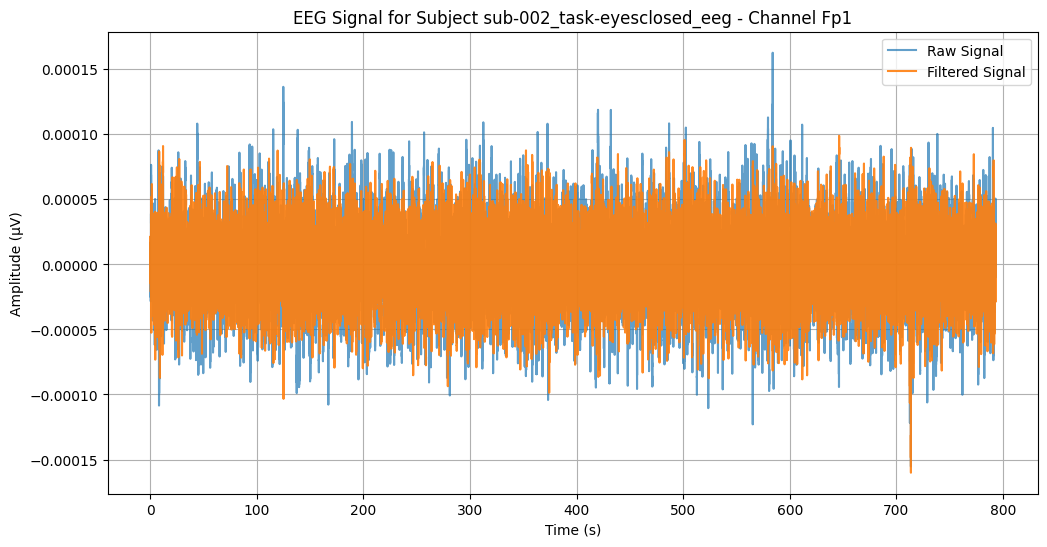

In [12]:
def plot_eeg_comparison(subject_id, channel, raw_df, filtered_df, time_col='Time'):
    """
    Plots the EEG signal before and after filtering for a specific subject and channel.

    Parameters:
    - subject_id: ID of the subject to plot.
    - channel: EEG channel to visualize.
    - raw_df: DataFrame with raw EEG data.
    - filtered_df: DataFrame with filtered EEG data.
    - time_col: Column name for the time axis (default: 'Time').
    """
    # Extract data for the selected subject
    raw_data = raw_df[raw_df['SubjectID'] == subject_id]
    filtered_data = filtered_df[filtered_df['SubjectID'] == subject_id]
    
    # Extract time and channel data
    time = raw_data[time_col]
    raw_signal = raw_data[channel]
    filtered_signal = filtered_data[channel]
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(time, raw_signal, label='Raw Signal', alpha=0.7)
    plt.plot(time, filtered_signal, label='Filtered Signal', alpha=0.9)
    plt.title(f"EEG Signal for Subject {subject_id} - Channel {channel}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plotting for a specific subject and channel
example_subject = eeg_df_filtered['SubjectID'].iloc[0]  # Replace with a valid SubjectID
example_channel = eeg_df_filtered.columns[0]  # Replace with a valid channel name

plot_eeg_comparison(example_subject, example_channel, eeg_df_resampled, eeg_df_filtered)

### 2.g Extract Epochs

In [13]:
def extract_epochs(data, epoch_length=2, overlap=1, sampling_rate=125):
    """
    Extract overlapping epochs from EEG data.

    Parameters:
    - data: DataFrame containing EEG data.
    - epoch_length: Length of each epoch in seconds (default: 5).
    - overlap: Overlap between epochs in seconds (default: 2.5).
    - sampling_rate: Sampling rate of the data in Hz (default: 250).

    Returns:
    - A list of DataFrames, each containing epochs for a single subject.
    """
    epochs_list = []
    samples_per_epoch = int(epoch_length * sampling_rate)
    overlap_samples = int(overlap * sampling_rate)
    
    for subject in data['SubjectID'].unique():
        subject_data = data[data['SubjectID'] == subject].reset_index(drop=True)
        channels = subject_data.columns[:-2]  # Exclude 'Time' and 'SubjectID'
        time = subject_data['Time']
        
        # Sliding window to extract epochs
        for start_idx in range(0, len(subject_data) - samples_per_epoch + 1, samples_per_epoch - overlap_samples):
            end_idx = start_idx + samples_per_epoch
            epoch = subject_data.iloc[start_idx:end_idx].copy()
            epoch['EpochID'] = f"{subject}_epoch_{start_idx // (samples_per_epoch - overlap_samples)}"
            epochs_list.append(epoch)
    
    return pd.concat(epochs_list, ignore_index=True)

# Apply epoch extraction
eeg_epochs = extract_epochs(eeg_df_filtered)

# Display results
print(f"Total number of epochs: {len(eeg_epochs['EpochID'].unique())}")
print(eeg_epochs.head())
print(eeg_epochs.tail())

Total number of epochs: 7088
            Fp1       Fp2            F3            F4        C3        C4  \
0 -2.842923e-06 -0.000002 -3.096580e-06 -2.780935e-06 -0.000003 -0.000003   
1 -8.923234e-06 -0.000010 -9.987967e-06 -8.514915e-06 -0.000011 -0.000010   
2 -8.143505e-06 -0.000016 -1.076443e-05 -6.434787e-06 -0.000014 -0.000012   
3  5.350485e-07 -0.000016 -4.211079e-06  1.625478e-06 -0.000010 -0.000006   
4  4.918008e-06 -0.000008  4.469195e-07 -6.991561e-07 -0.000004 -0.000002   

         P3        P4        O1        O2  ...        T3        T4        T5  \
0 -0.000003 -0.000002 -0.000002 -0.000003  ... -0.000002 -0.000001 -0.000002   
1 -0.000011 -0.000009 -0.000009 -0.000012  ... -0.000009 -0.000006 -0.000009   
2 -0.000017 -0.000012 -0.000014 -0.000018  ... -0.000017 -0.000014 -0.000015   
3 -0.000014 -0.000007 -0.000013 -0.000014  ... -0.000017 -0.000015 -0.000014   
4 -0.000005 -0.000001 -0.000006 -0.000008  ... -0.000006 -0.000007 -0.000005   

             T6        Fz  

### 2.h Compute bands for EEG signals

In [14]:
# Precompute band-filtered signals for all bands
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 25),
    "gamma": (25, 48)
}

# Dictionary to store filtered signals
filtered_signals = {}

for band_name, (low, high) in bands.items():
    print(f"Filtering for band: {band_name}")
    filtered_signals[band_name] = apply_filter(
        eeg_df_filtered.iloc[:, :-2].to_numpy(), low, high, fs=125
    )

Filtering for band: delta
Filtering for band: theta
Filtering for band: alpha
Filtering for band: beta
Filtering for band: gamma


### 2.i Compute mean and standard deviation for each band

In [15]:
def compute_features(epoch_data, bands):
    """
    Compute features from an epoch.

    Parameters:
    - epoch_data: DataFrame containing an epoch.
    - bands: Dictionary with frequency bands.

    Returns:
    - Dictionary of computed features.
    """
    features = {}
    for band_name, (low, high) in bands.items():
        # Band-filtered signal
        filtered_signal = apply_filter(epoch_data.iloc[:, :-3].to_numpy(), low, high, fs=125)
        features[f"{band_name}_mean"] = np.mean(filtered_signal, axis=0)
        features[f"{band_name}_std"] = np.std(filtered_signal, axis=0)
    
    # Statistical features
    features["variance"] = np.var(epoch_data.iloc[:, :-3].to_numpy(), axis=0).mean()
    features["iqr"] = iqr(epoch_data.iloc[:, :-3].to_numpy(), axis=0).mean()

    return features

# Iterate over epochs and compute features
features_list = []
for epoch_id in eeg_epochs['EpochID'].unique():
    epoch_data = eeg_epochs[eeg_epochs['EpochID'] == epoch_id]
    subject_id = epoch_data['SubjectID'].iloc[0]
    features = compute_features(epoch_data, bands)
    features["SubjectID"] = subject_id
    features["EpochID"] = epoch_id
    features_list.append(features)

# Combine features into a DataFrame
features_df = pd.DataFrame(features_list)
print(features_df.head())

                                          delta_mean  \
0  [-1.6781017070254205e-06, -1.7123294374137073e...   
1  [-5.257119851793629e-07, 4.872297290919631e-08...   
2  [-1.0363660118215728e-06, -1.789518437934957e-...   
3  [-1.8973198565814308e-06, -1.5725278661847032e...   
4  [-1.002990663673161e-06, -9.830230191039228e-0...   

                                           delta_std  \
0  [1.8050236124680028e-05, 1.9855321476235435e-0...   
1  [1.862113437501421e-05, 1.924657178087629e-05,...   
2  [1.401561669235248e-05, 1.5174919431853805e-05...   
3  [1.5882513399874972e-05, 1.608697878538183e-05...   
4  [1.769335909279158e-05, 1.6907595692844376e-05...   

                                          theta_mean  \
0  [-4.1785259483272656e-08, -1.6562922751066727e...   
1  [8.574648109045005e-08, 7.897188356359211e-08,...   
2  [5.393653364282815e-08, 5.351011344193526e-08,...   
3  [1.4117316943846603e-08, 2.0471630571520484e-0...   
4  [4.544351433767462e-08, 1.887120444783199e-

### 2.j Merge feature dataframe with subject group

In [16]:
print(patient_df.head())

# Ensure subject IDs match format in patient_df
features_df['SubjectID'] = features_df['SubjectID'].str.extract(r"(sub-\d+)")

# Merge with metadata
combined_df = pd.merge(features_df, patient_df[['SubjectID', 'Group']], on='SubjectID', how='inner')

print(combined_df.head())
print(combined_df.tail())

# Check the column types to ensure they are all numeric
print(combined_df.dtypes)


  SubjectID Gender  Age Group  MMSE
0   sub-001      F   57     A    16
1   sub-002      F   78     A    22
2   sub-003      M   70     A    14
3   sub-004      F   67     A    20
4   sub-005      M   70     A    22
                                          delta_mean  \
0  [-1.6781017070254205e-06, -1.7123294374137073e...   
1  [-5.257119851793629e-07, 4.872297290919631e-08...   
2  [-1.0363660118215728e-06, -1.789518437934957e-...   
3  [-1.8973198565814308e-06, -1.5725278661847032e...   
4  [-1.002990663673161e-06, -9.830230191039228e-0...   

                                           delta_std  \
0  [1.8050236124680028e-05, 1.9855321476235435e-0...   
1  [1.862113437501421e-05, 1.924657178087629e-05,...   
2  [1.401561669235248e-05, 1.5174919431853805e-05...   
3  [1.5882513399874972e-05, 1.608697878538183e-05...   
4  [1.769335909279158e-05, 1.6907595692844376e-05...   

                                          theta_mean  \
0  [-4.1785259483272656e-08, -1.6562922751066727e...  

In [17]:
def compute_mean(value):
    # Check if the value is a numpy array and compute the mean
    return np.mean(value) if isinstance(value, np.ndarray) else np.nan

# Columns to process
columns_to_process = [
    'delta_mean', 'delta_std', 'theta_mean', 'theta_std',
    'alpha_mean', 'alpha_std', 'beta_mean', 'beta_std',
    'gamma_mean', 'gamma_std'
]

# Apply the computation
for col in columns_to_process:
    combined_df[col] = combined_df[col].apply(compute_mean)

# Check for NaN values after processing
print(combined_df.isna().sum())


delta_mean    0
delta_std     0
theta_mean    0
theta_std     0
alpha_mean    0
alpha_std     0
beta_mean     0
beta_std      0
gamma_mean    0
gamma_std     0
variance      0
iqr           0
SubjectID     0
EpochID       0
Group         0
dtype: int64


### 2.k Convert all datatypes to numeric and fill NaN values

In [18]:
# Drop non-numeric columns (SubjectID and EpochID) before applying transformations
combined_df_numeric = combined_df.drop(columns=['SubjectID', 'EpochID','Group'])

# Convert list-like columns to numeric (mean of the list)
for col in ['delta_mean', 'delta_std', 'theta_mean', 'theta_std', 'alpha_mean', 'alpha_std', 
            'beta_mean', 'beta_std', 'gamma_mean', 'gamma_std']:
    combined_df_numeric[col] = combined_df_numeric[col].apply(lambda x: np.mean(eval(x)) if isinstance(x, str) else np.mean(x))

# Now, check for NaN values in the numeric dataframe
print(combined_df_numeric.isna().sum())

# Fill NaN values with the mean of each column
combined_df_numeric.fillna(combined_df_numeric.mean(), inplace=True)

# Check the column types to ensure they are all numeric
print(combined_df_numeric.dtypes)

# Reattach non-numeric columns to the numeric dataframe
combined_df_final = pd.concat([combined_df[['SubjectID', 'EpochID','Group']], combined_df_numeric], axis=1)

# Check the result
print(combined_df_final.head())


delta_mean    0
delta_std     0
theta_mean    0
theta_std     0
alpha_mean    0
alpha_std     0
beta_mean     0
beta_std      0
gamma_mean    0
gamma_std     0
variance      0
iqr           0
dtype: int64
delta_mean    float64
delta_std     float64
theta_mean    float64
theta_std     float64
alpha_mean    float64
alpha_std     float64
beta_mean     float64
beta_std      float64
gamma_mean    float64
gamma_std     float64
variance      float64
iqr           float64
dtype: object
  SubjectID                              EpochID Group    delta_mean  \
0   sub-002  sub-002_task-eyesclosed_eeg_epoch_0     A -1.661666e-06   
1   sub-002  sub-002_task-eyesclosed_eeg_epoch_1     A -1.293883e-07   
2   sub-002  sub-002_task-eyesclosed_eeg_epoch_2     A -1.550733e-06   
3   sub-002  sub-002_task-eyesclosed_eeg_epoch_3     A -1.537147e-06   
4   sub-002  sub-002_task-eyesclosed_eeg_epoch_4     A -8.702684e-07   

   delta_std    theta_mean  theta_std    alpha_mean  alpha_std     beta_mean  \
0   

## 3. Prepare for Modeling

### 3.a Train/Test/Validation Split

In [19]:
# Separate features and labels
X = combined_df.drop(columns=['SubjectID', 'EpochID', 'Group'])
y = combined_df['Group']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'A', 'C', 'F' into 0, 1, 2

# Split data into train, validation, and test sets (60%, 20%, 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Ensure numeric types for all datasets
X_train = X_train.apply(pd.to_numeric, errors='coerce').astype('float64')
X_val = X_val.apply(pd.to_numeric, errors='coerce').astype('float64')
X_test = X_test.apply(pd.to_numeric, errors='coerce').astype('float64')

# Standardize features
scaler = StandardScaler()

# Fit the scaler on the training set and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Check shapes after scaling
print("X_train_scaled:", X_train_scaled.shape, "y_train:", y_train.shape)
print("X_val_scaled:", X_val_scaled.shape, "y_val:", y_val.shape)
print("X_test_scaled:", X_test_scaled.shape, "y_test:", y_test.shape)


X_train_scaled: (4252, 12) y_train: (4252,)
X_val_scaled: (1418, 12) y_val: (1418,)
X_test_scaled: (1418, 12) y_test: (1418,)


## 4. Random Forest Classifier

In [20]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: Evaluate on the validation and test set
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Print classification report for both validation and test sets
print("Random Forest - Validation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred))
print("\nRandom Forest - Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))

Random Forest - Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.28      0.35       469
           1       0.41      0.85      0.56       506
           2       0.79      0.14      0.24       443

    accuracy                           0.44      1418
   macro avg       0.55      0.43      0.38      1418
weighted avg       0.55      0.44      0.39      1418


Random Forest - Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.28      0.35       493
           1       0.42      0.87      0.57       505
           2       0.74      0.16      0.26       420

    accuracy                           0.45      1418
   macro avg       0.55      0.43      0.39      1418
weighted avg       0.53      0.45      0.40      1418



## 5. Logistic Regression (for multiclass classification)

In [21]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

y_val_pred = logreg_model.predict(X_val)
y_test_pred = logreg_model.predict(X_test)

# Print classification report for both validation and test sets
print("Logistic Regression - Validation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred))
print("\nLogistic Regression - Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))


Logistic Regression - Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       469
           1       0.36      1.00      0.53       506
           2       0.00      0.00      0.00       443

    accuracy                           0.36      1418
   macro avg       0.12      0.33      0.18      1418
weighted avg       0.13      0.36      0.19      1418


Logistic Regression - Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       493
           1       0.36      1.00      0.53       505
           2       0.00      0.00      0.00       420

    accuracy                           0.36      1418
   macro avg       0.12      0.33      0.18      1418
weighted avg       0.13      0.36      0.19      1418



c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## 6. SVM

In [22]:
svm_model = SVC(kernel = 'rbf', random_state=42)
svm_model.fit(X_train, y_train)

y_val_pred = svm_model.predict(X_val)
y_test_pred = svm_model.predict(X_test)

# Print classification report for both validation and test sets
print("SVM - Validation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred))
print("\nSVM - Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))

SVM - Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.47      0.49       469
           1       0.55      0.68      0.61       506
           2       0.53      0.43      0.47       443

    accuracy                           0.53      1418
   macro avg       0.53      0.53      0.52      1418
weighted avg       0.53      0.53      0.53      1418


SVM - Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.45      0.48       493
           1       0.52      0.64      0.57       505
           2       0.52      0.43      0.47       420

    accuracy                           0.51      1418
   macro avg       0.51      0.51      0.51      1418
weighted avg       0.51      0.51      0.51      1418



## 7. KNN

In [23]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

y_val_pred = knn_model.predict(X_val)
y_test_pred = knn_model.predict(X_test)

# Print classification report for both validation and test sets
print("KNN - Validation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred))
print("\nKNN - Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))

KNN - Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.60      0.51       469
           1       0.55      0.50      0.53       506
           2       0.58      0.43      0.50       443

    accuracy                           0.51      1418
   macro avg       0.53      0.51      0.51      1418
weighted avg       0.53      0.51      0.51      1418


KNN - Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.59      0.53       493
           1       0.53      0.51      0.52       505
           2       0.53      0.40      0.46       420

    accuracy                           0.50      1418
   macro avg       0.51      0.50      0.50      1418
weighted avg       0.51      0.50      0.50      1418



## 8. Gradient Boosting Classifier

In [24]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_val_pred = gb_model.predict(X_val)
y_test_pred = gb_model.predict(X_test)

# Print classification report for both validation and test sets
print("Gradient Boosting - Validation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred))
print("\nGradient Boosting - Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))

Gradient Boosting - Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.10      0.16       469
           1       0.37      0.96      0.54       506
           2       0.60      0.06      0.11       443

    accuracy                           0.39      1418
   macro avg       0.52      0.37      0.27      1418
weighted avg       0.51      0.39      0.28      1418


Gradient Boosting - Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.07      0.12       493
           1       0.36      0.93      0.52       505
           2       0.62      0.08      0.14       420

    accuracy                           0.38      1418
   macro avg       0.48      0.36      0.26      1418
weighted avg       0.47      0.38      0.27      1418



## 9. Multi-Layer Perceptron (MLP) Classifier

In [25]:
mlp_model = MLPClassifier(max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

y_val_pred = mlp_model.predict(X_val)
y_test_pred = mlp_model.predict(X_test)

# Print classification report for both validation and test sets
print("MLP - Validation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred))
print("\nMLP - Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))

MLP - Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       469
           1       0.36      1.00      0.53       506
           2       0.00      0.00      0.00       443

    accuracy                           0.36      1418
   macro avg       0.12      0.33      0.18      1418
weighted avg       0.13      0.36      0.19      1418


MLP - Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       493
           1       0.36      1.00      0.53       505
           2       0.00      0.00      0.00       420

    accuracy                           0.36      1418
   macro avg       0.12      0.33      0.18      1418
weighted avg       0.13      0.36      0.19      1418



c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## 10. XGBoost

In [26]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Print classification report for both validation and test sets
print("XGBoost - Validation Set Classification Report:\n")
print(classification_report(y_val, y_val_pred))
print("\nXGBoost - Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))

XGBoost - Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       469
           1       0.75      0.72      0.73       506
           2       0.67      0.70      0.68       443

    accuracy                           0.68      1418
   macro avg       0.68      0.68      0.68      1418
weighted avg       0.68      0.68      0.68      1418


XGBoost - Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       493
           1       0.74      0.75      0.75       505
           2       0.68      0.74      0.71       420

    accuracy                           0.70      1418
   macro avg       0.70      0.70      0.70      1418
weighted avg       0.70      0.70      0.70      1418



## 11. Hyperparameter Tuning

In [ ]:
# Models and their hyperparameter grids
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
        },
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
        },
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan'],
        },
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
        },
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
        },
    },
    'MLP': {
        'model': MLPClassifier(random_state=42),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'learning_rate_init': [0.001, 0.01],
        },
    },
}

In [28]:
# Loop through each model
best_models = {}

for name, model_info in models_and_params.items():
    print(f"Starting hyperparameter tuning for {name}...")
    
    # Define GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='accuracy',
        cv=5,  # 5-fold cross-validation
        verbose=2,
        n_jobs=-1  # Use all processors
    )
    
    # Perform the grid search
    grid_search.fit(X_train, y_train)
    
    # Store the best model and parameters
    best_models[name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
    }

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_}")

Starting hyperparameter tuning for RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score for RandomForest: 0.4920049768438516
Starting hyperparameter tuning for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score for SVM: 0.5658522153867422
Starting hyperparameter tuning for KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation score for KNN: 0.5505705398493123
Starting hyperparameter tuning for GradientBoosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200}
Best c

## 12. Model Comparison

In [29]:
# Evaluate each model
for name, model_info in best_models.items():
    print(f"Evaluating {name} on test data...")
    
    # Get the best model
    best_model = model_info['best_estimator']
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Print classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

Evaluating RandomForest on test data...
Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.49      0.31      0.38       493
           1       0.42      0.85      0.56       505
           2       0.69      0.14      0.23       420

    accuracy                           0.45      1418
   macro avg       0.53      0.43      0.39      1418
weighted avg       0.52      0.45      0.40      1418

Evaluating SVM on test data...
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       493
           1       0.63      0.64      0.64       505
           2       0.57      0.62      0.60       420

    accuracy                           0.59      1418
   macro avg       0.59      0.59      0.59      1418
weighted avg       0.59      0.59      0.59      1418

Evaluating KNN on test data...
Classification Report for KNN:
              precision    recall 

c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [30]:
# Initialize a DataFrame to store metrics
metrics_summary = []

# Extract performance metrics from classification reports
for name, model_info in best_models.items():
    # Get the best model
    best_model = model_info['best_estimator']
    
    # Predict on test data
    y_pred = best_model.predict(X_test)
    
    # Generate classification report as a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract metrics for the 'weighted avg' row (or another specific class if desired)
    weighted_avg = report['weighted avg']
    metrics_summary.append({
        'Model': name,
        'Precision': weighted_avg['precision'],
        'Recall': weighted_avg['recall'],
        'F1-Score': weighted_avg['f1-score'],
        'Accuracy': report['accuracy'],  # Overall accuracy
    })

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

              Model  Precision    Recall  F1-Score  Accuracy
0      RandomForest   0.522344  0.452045  0.400838  0.452045
1               SVM   0.586639  0.587447  0.586316  0.587447
2               KNN   0.541698  0.540903  0.541110  0.540903
3  GradientBoosting   0.488070  0.398449  0.310071  0.398449
4           XGBoost   0.707995  0.708745  0.707266  0.708745
5               MLP   0.126832  0.356135  0.187050  0.356135


c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [31]:
# Save classification reports to a .txt file
with open('classification_reports.txt', 'w') as f:
    for name, model_info in best_models.items():
        # Get the best model
        best_model = model_info['best_estimator']
        
        # Predict on test data
        y_pred = best_model.predict(X_test)
        
        # Generate classification report
        report = classification_report(y_test, y_pred)
        
        # Write to file
        f.write(f"Classification Report for {name}:\n")
        f.write(report)
        f.write("\n" + "="*80 + "\n")


c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

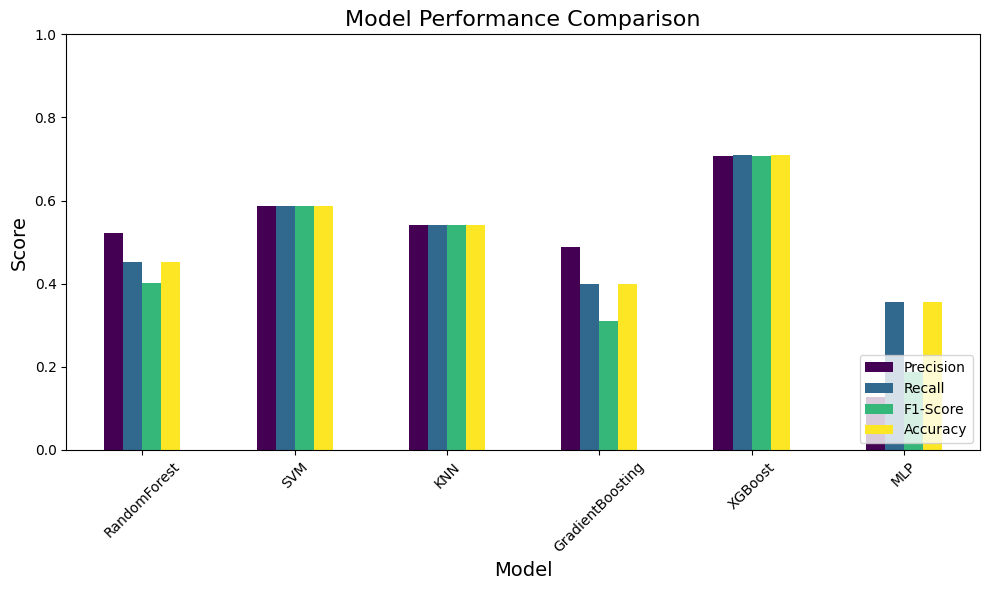

In [32]:
# Plot the metrics
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6), rot=45, colormap='viridis')

# Add title and labels
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0, 1)  # Since metrics are between 0 and 1
plt.legend(loc='lower right')
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('model_comparison.pdf')
plt.show()
